In [9]:
import numpy as np

[[9900.  100.    0.]
 [9899.  100.    0.]
 [9899.  100.    0.]
 ...
 [2182.  256. 7561.]
 [2182.  256. 7561.]
 [2182.  256. 7561.]]


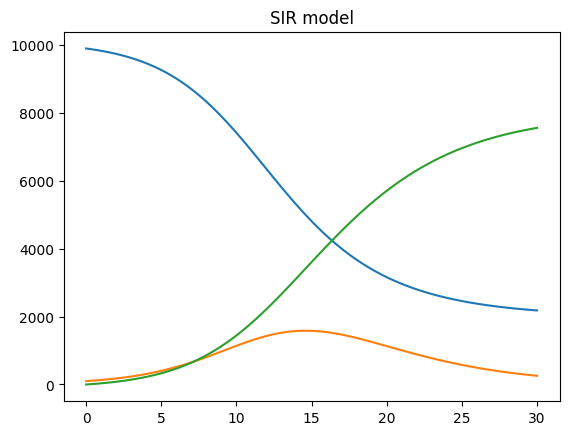

In [10]:
# Define 4-th order runge-kutta 
def rk_4(y_0,t,f,args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y

# Define parameters of SIR model 
N=1e4 # The whole population 
y0=np.array([N-100, 100, 0]) 
beta=0.6 # Infection rate 
gamma=0.3  # Removal reate 
T_max= 30 # total days in consideration 
dt=1e-3
T_num=int(T_max/dt)
t= np.linspace(start=0,stop=T_max,num=int(T_num))

# Define f_SIR
def f_SIR(y,t,N,beta, gamma):
    f_SIR=np.zeros(3)
    f_SIR[0]= - beta/N*y[0]*y[1]
    f_SIR[1]= beta/N*y[0]*y[1]-gamma*y[1]
    f_SIR[2]= gamma*y[1]
    return f_SIR 

# Compute the value of SIR 
y=rk_4(y0, t, f_SIR,args=(N, beta, gamma))

for i in range(y.shape[0]):
    for j in range(y.shape[1]):
        y[i][j] = int(y[i][j])


import matplotlib.pyplot as plt
for i in range(3): 
    plt.plot(t, y[:,i])
plt.title("SIR model")

print(y)


# for i in range(y.shape[0]):
#     for j in range(y.shape[1]):
#         y[i][j] = int(y[i][j])
# for i in range(3): 
#     plt.plot(t, y[:,i])
# plt.title("SIR model")



In [11]:
y_real=y.astype(int)
# Introduce poisson noise 
np.random.seed(0)
y_observed=[]
t_observed=[]
for i in range(len(y_real)): 
    if i % (len(y_real)/100)==0: 
        y_observed.append(y_real[i])
        t_observed.append(t[i])
y_observed=np.vstack(y_observed)
y_observed=np.random.poisson(y_observed)


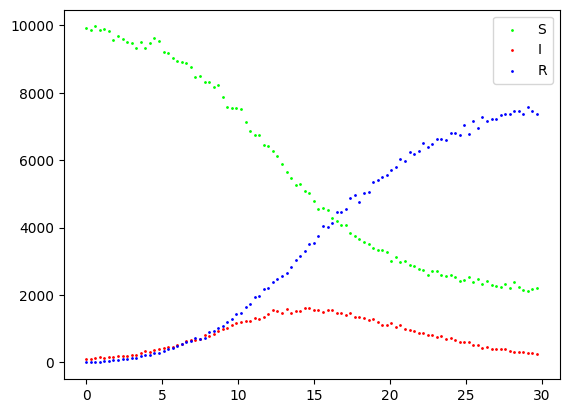

In [12]:
import matplotlib.pyplot as plt
plt.scatter(t_observed, y_observed[:,0],color=(0,1,0),label="S",s=1)
plt.scatter(t_observed, y_observed[:,1],color=(1,0,0),label="I",s=1)
plt.scatter(t_observed, y_observed[:,2],color=(0,0,1),label="R",s=1)

plt.legend()

In [16]:
import pyprob
from pyprob import Model
from pyprob.distributions import Uniform, Poisson, Normal
from torch import tensor
import torch

class SIRModel(Model):
    def __init__(self, y0, T_max, steps):
        self.y0 = y0
        self.T_max = 100
        self.steps = steps
        super().__init__()

    def forward(self):
        beta = pyprob.sample(Normal(0.5, 0.1), name="beta").item()
        gamma = pyprob.sample(Normal(0.5, 0.1), name="gamma").item()

        y_mean = torch.zeros(self.steps, 3)

        y_mean[0] = self.y0
     
        

        def f(y):
            return tensor([-beta / N * y[0] * y[1], beta / N * y[0] * y[1] - gamma * y[1], 0])

        h = self.T_max / self.steps

        for i in range(self.steps -1):
            
            k1 = f(y_mean[i])
            k2 = f(y_mean[i] + k1 * h / 2.)
            k3 = f(y_mean[i] + k2 * h / 2.)
            k4 = f(y_mean[i] + k3 * h)
            y_mean[i+1] = y_mean[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)


#         for i in range(y_mean.shape[0]):
#             for j in range(y_mean.shape[1]):
#                 pyprob.observe(Poisson(int(y_mean[i][j].item())), name=str(i)+str(j))
        for i in range(y_mean.shape[0]):
            for j in range(y_mean.shape[1]):
#                 print(y_mean[i])
                y_mean[i][j] = int(y_mean[i][j])
        pyprob.observe(Poisson(y_mean), name="y")
        
        return beta, gamma


In [17]:
y0 = tensor([9900.0, 100.0, 0.0])
T_max = 100
steps = 100
sirModel = SIRModel(y0, T_max, steps)

In [18]:
prior = sirModel.prior_results(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:45 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 21.96       


In [19]:
print(prior.sample())

(0.6806380152702332, 0.6986241936683655)


Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 64,331.00       
mean for beta = tensor(0.4972)
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 59,925.47       
mean for gamma = tensor(0.4993)


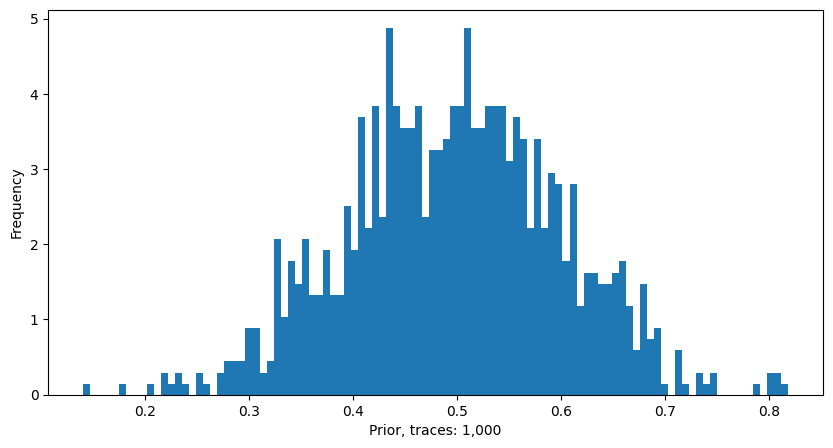

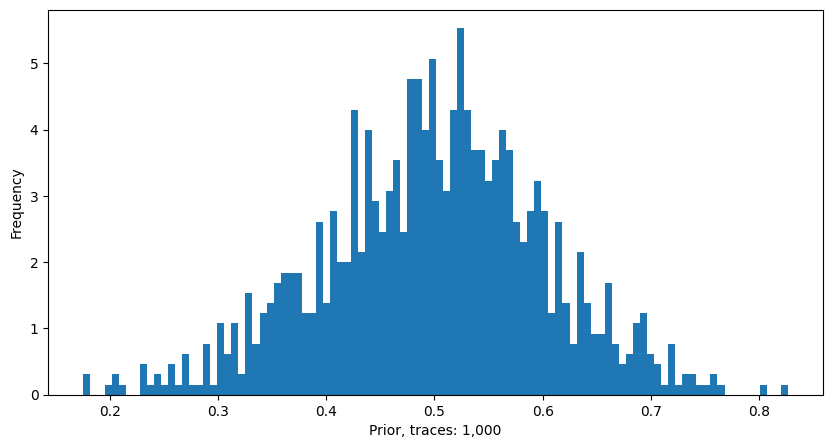

In [20]:
prior_first = prior.map(lambda v: v[0]) 
print("mean for beta =",prior_first.mean)
prior_second = prior.map(lambda v: v[1])
print("mean for gamma =",prior_second.mean)

prior_first.plot_histogram(show=True, bins=100)
prior_second.plot_histogram(show=True, bins=100)

In [22]:
observedic = {}

N=1e4 # The whole population 
y0=np.array([N-100, 100, 0]) 
beta=0.6 # Infection rate 
gamma=0.3  # Removal reate 
T_max= 100 # total days in consideration 
dt=1
T_num=int(T_max/dt)
t= np.linspace(start=0,stop=T_max,num=int(T_num))
y = rk_4(y0, t, f_SIR,args=(N, beta, gamma))

for i in range(y.shape[0]):
    for j in range(y.shape[1]):
        y[i][j] = int(y[i][j])
        
print(y[1][2])

observedic["y"] = y

# for i in range(0,5):
#     y = rk_4(y0, t, f_SIR,args=(N, beta, gamma))
#     for i in range(y.shape[0]):
#         for j in range(y.shape[1]):
#             if str(i)+str(j) in observedic:
#                 observedic[str(i)+str(j)].append(int(y[i][j].item()))
#             else:
# #         print(type())
#                 observedic[str(i)+str(j)] = [int(y[i][j])]
    
    
print(len(observedic))
# print(len(observedic["00"]))

35.0
1


In [23]:
posterior = sirModel.posterior_results(
                    num_traces=3000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS, 
                    observe= observedic )

Time spent  | Time remain.| Progress             | Trace     | Accepted|Smp reuse| Traces/sec
0d:00:02:18 | 0d:00:00:00 | #################### | 3000/3000 |   0.00% |  50.00% | 21.63       


Map, min_index: 0, max_index: 3000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 3000/3000 | 59,578.86       
mean for beta = tensor(0.4995)
Map, min_index: 0, max_index: 3000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 3000/3000 | 59,128.26       
mean for gamma = tensor(0.6693)


<IPython.core.display.Javascript object>


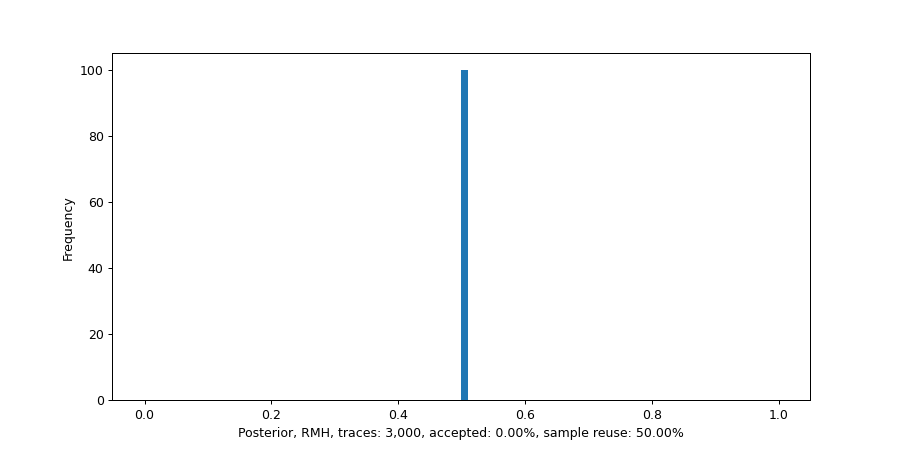

Empirical(items:3000, weighted:False)

<IPython.core.display.Javascript object>


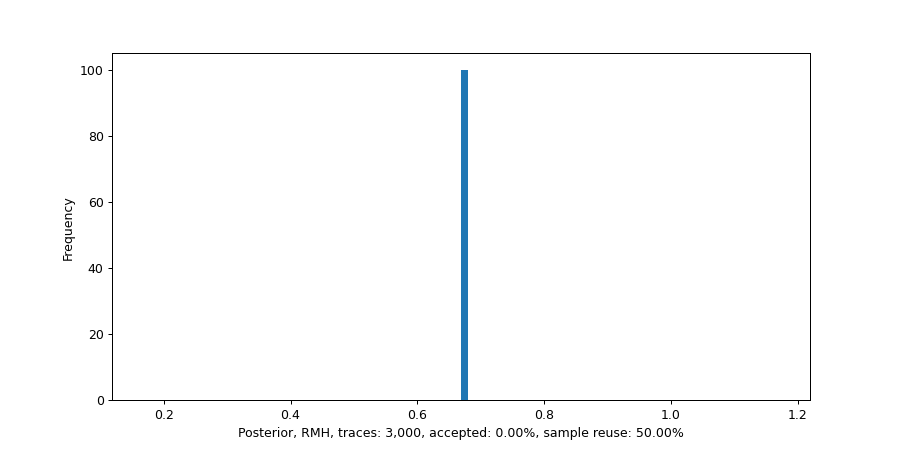

In [24]:
posterior_first = posterior.map(lambda v: v[0]) 
print("mean for beta =",posterior_first.mean)
posterior_second = posterior.map(lambda v: v[1])
print("mean for gamma =",posterior_second.mean)
%matplotlib notebook

from IPython.display import display

posterior_first.plot_histogram(show=True, bins=100)
display(posterior_first)
posterior_second.plot_histogram(show=True, bins=100)